# Exercícios da Aula 05 - Detecção de Bordas
### Samuel Felipe dos Santos

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from math import exp
import os
from sklearn.preprocessing import normalize

### Ex 1:

**● Implemente um detector de pontos.**

**● Faça uma variação da implementação que detecte
pontos de tamanhos variados.**

**– O tamanho do ponto deve ser um parâmetro de raio.**

**– Os tamanhos dos pontos correspondem ao tamanho do
objeto, de acordo com a escala da imagem.**

**● Escolha 5 imagens para as quais o detector funciona
bem.**

**– A variação deve ser detectada na intensidade e não nas cores.**

**– Use a conversão de RGB para HSI para calcular a intensidade.**

Inicialmente, foram reaproveitadas as implementações das funções de padding, correlação e normalização da aula 04.

In [4]:
#Implementação de padding com zeros utilizado pela função de correlação 
def pad(image, u,d,l,r):
    paded_image = np.zeros([image.shape[0]+u+d, image.shape[1]+l+r])
    paded_image[u:paded_image.shape[0]-d, l:paded_image.shape[1]-r] = image
    return paded_image

#Implementação da função de correlação entre uma imagem e uma máscara
def correlation(image, mask, function=np.sum):
    u = int(mask.shape[0]/2)
    d = mask.shape[0]-1-u
    l = int(mask.shape[1]/2)
    r = mask.shape[1]-1-l
    
    img_shape = image.shape
    p_image = pad(image, u, d, l, r)
    
    out = np.zeros(img_shape[:2])
    for i in range(u, u+img_shape[0]-1):
        for j in range(l, l+img_shape[1]-1):
            out[i-u,j-l] = function( mask *  p_image[ i-u :i+1+d, j-l:j+1+r ] )
    return out

#faz com que os pixels da imagem variem entre os valores de  img_min e img_max
def rescale(img, img_min, img_max):
    mn = img.min()
    mx = img.max()
    return ((img-mn)/(mx-mn)*(img_max-img_min) + img_min)

Foram então implmentados as funções de conversão do espaço de cor BGR para RGB, já que o OpenCV le as imagens em BGR mas o pyplot exibe imagens em RGB, e a função que calcula a intensidade dos pontos de acordo com o espaço de cor HSI, já que a detecção de pontos será realizada na intensidade.

In [5]:
def bgr_to_rgb(img):
    return img[...,[2,1,0]]

def Intensity(img):
    return np.sum(img, axis=-1)/3

Abaixo uma imagens de teste são abertas, sendo calculadas suas intensidades (I do HSI)

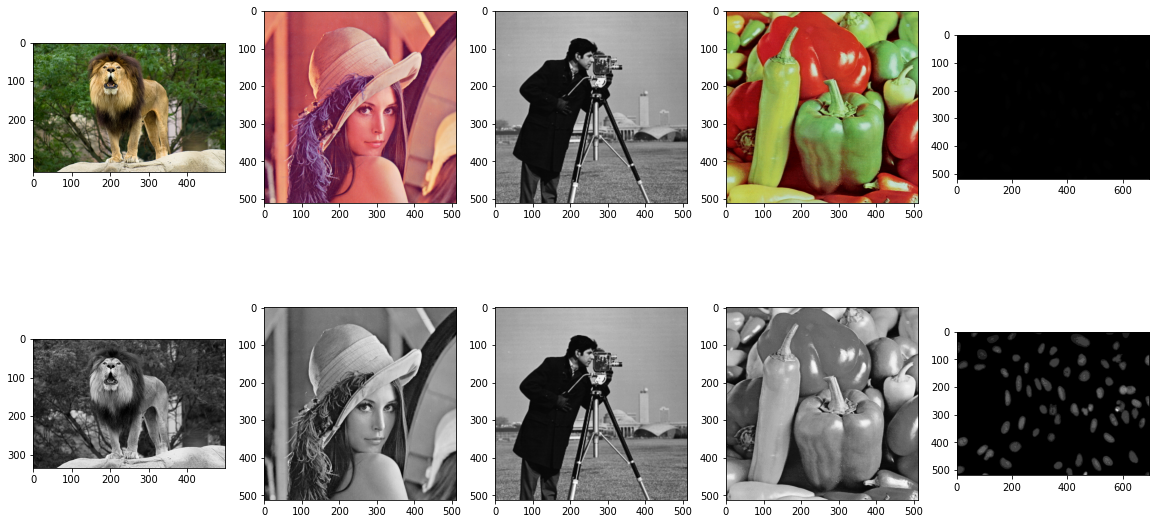

In [104]:
fig = plt.figure(figsize=(20, 10))

images_path = [ 'lion.jpg',
                'data/aula04/standard_test_images/lena_color_512.tif',
                'data/aula04/standard_test_images/cameraman.tif',
                'data/aula04/standard_test_images/peppers_color.tif',
                'data/aula05/cells/IXMtest_A01_s1_w164FBEEF7-F77C-4892-86F5-72D0160D4FB2.tif']

imgs_i = []

i=1
for file_name in images_path:
    img = bgr_to_rgb(cv.imread(file_name, 1))
    img_i = Intensity(rescale(img, 0, 1)) 

    fig.add_subplot(2, len(files), i)
    plt.imshow(img)

    fig.add_subplot(2, len(files), len(files)+i)
    plt.imshow(img_i, cmap='gray')
    
    imgs_i += [img_i]
    
    i+=1

Abaixo foram implementados a funções do Laplaciano da Gaussiana e de limiar.

A função do Laplaciano da gaussiana equivale a aplicar o laplaciano em uma imagem suavizada por um filtro gaussiano.

A ideia da abordagem será aumentar o da constante sigma para identificar pontos maiores, mantendo uma máscara 3 vezes maior que o sigma para que possa cobrir a região ao redor do ponto.

Foi usada a seguinte fórmula para definir o sigma em relação ao raio r:  sigma=r/sqrt(2)

In [6]:
def LoG_kernel(shape, sigma):
    LoG = np.zeros(shape)
    center = [int(shape[0]/2), int(shape[1]/2)]
    for i in range(shape[0]):
        for j in range(shape[1]):
            x = i-center[0]
            y = j-center[1]           
            LoG[j,i] = (-1.0/(np.pi*pow(sigma,4))*(1-(x**2+y**2)/(2*sigma**2))* exp(-(x**2+y**2)/(2*sigma**2)))
    return LoG


def threshold(img, threshold):
    b_img = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if abs(img[i,j]) > threshold:
                b_img[i,j] = 1
    return b_img

def radius_to_sigma(radius):
    return radius/np.sqrt(2)

O algoritmo abaixo descreve a abordagem utilizada, onde se é calculado o laplaciano da gaussiana da imagem, e então um limiar do valor absoluto.

O valor de sigma é calculado por meio do raio r fornecido, sendo sigma=r/sqrt(2).

O valor de janela foi definido como 3 vezes o de sigma mais 1

O valor do limiar foi testado entre 10%, 30%, 60%, 70% e 80% da intensidade máxima.

E o valor do raio foi variado entre 3, 9, 15, 19 e 25

Devido a grande quantidade de resultados gerados, será exibido apenas a melhor configuração.

In [7]:
def detect_blob(img, radius, t=0.8, w_ratio=3):
    sigma = radius_to_sigma(radius)
    windown_size = int(np.ceil(w_ratio*sigma+1))
    if windown_size%2 == 0:
        windown_size+=1
    
    log_kernel=LoG_kernel([windown_size,windown_size],sigma)
    co_img = correlation(img, log_kernel)
    
    max_value = co_img.max()
    if abs(co_img.min()) > max_value:
        max_value = abs(co_img.min())
    
    t_img  = threshold(co_img, max_value*t)
     
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    
    axes[0].set_title('radius='+str(radius)+' sigma='+str(sigma)+' windown='+str(windown_size)+' threshold='+str(t))
    axes[0].imshow(img, cmap='gray')


    axes[1].imshow(co_img, cmap='gray')
    
    axes[2].imshow(t_img, cmap='gray')
    
    
    figure.tight_layout()

As imagens abaixo mostram a itensidade da imagem original, o laplaciano da gaussiano, e o resultado final após a limiarização.

Para o leão foi escolhido o raio de 3, com limiar de 70%, e como pode ser visto foram reconhecidos o nariz, boca e olhos do leão como pontos.
Detalhes do chão e de algumas árvores também foram marcados como pontos.

In [ ]:
img = imgs_i[0]
for radius in [3,9,15,19,25]:
    for t in [0.1, 0.3, 0.6, 0.7]:
        detect_blob(img, radius, t=t)

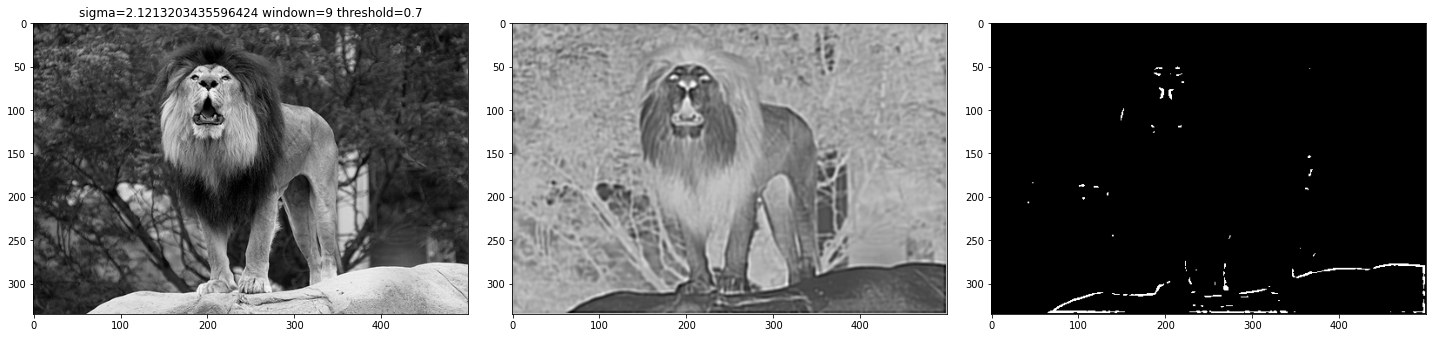

In [106]:
detect_blob(img, radius=3, t=0.7)

Nessa imagem pode ser visto que foram destacados os olhos , detalhes do nariz, boca e chapéu.

In [ ]:
img = imgs_i[1]
for radius in [3,9,15,19,25]:
    for t in [0.1, 0.3, 0.6, 0.7, 0.8]:
        detect_blob(img, radius, t=t)

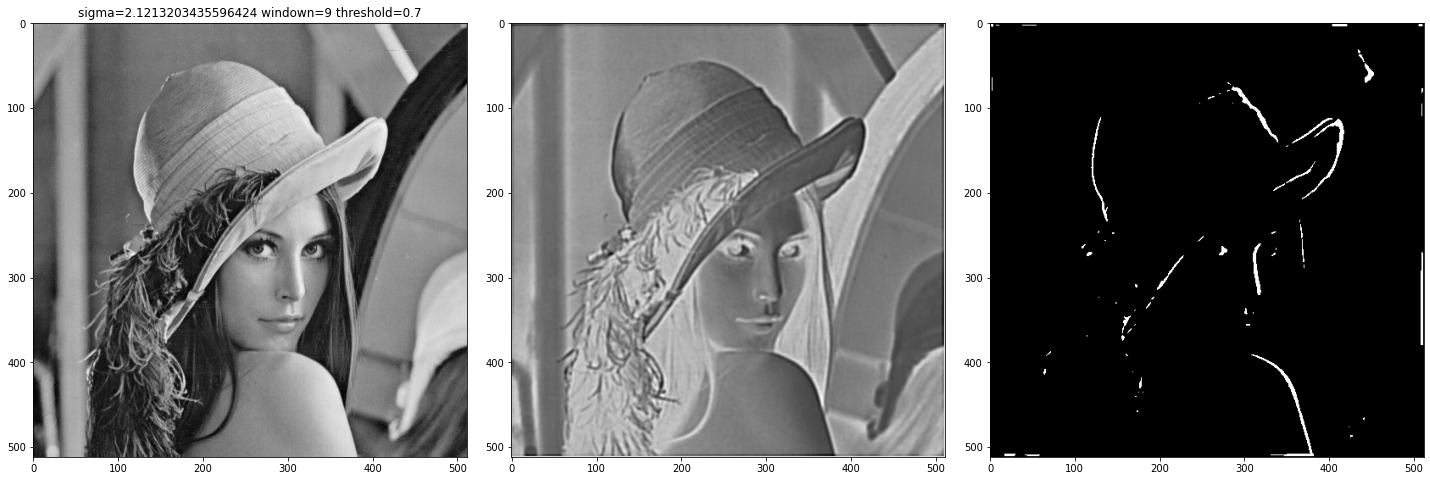

In [109]:
detect_blob(img, radius=3, t=0.7)

Nessa imagem foi escolhido um ponto de tamanho maior, com raio de 9, como pode ser visto foram detectados regiões arredondadas maiores, destacando uma peça da câmera maior, um pedaço do tripé e dois pedaços de prédio.

In [ ]:
img = imgs_i[2]
for radius in [3,9,15,19,25]:
    for t in [0.1, 0.3, 0.6, 0.7, 0.8]:
        detect_blob(img, radius, t=t)

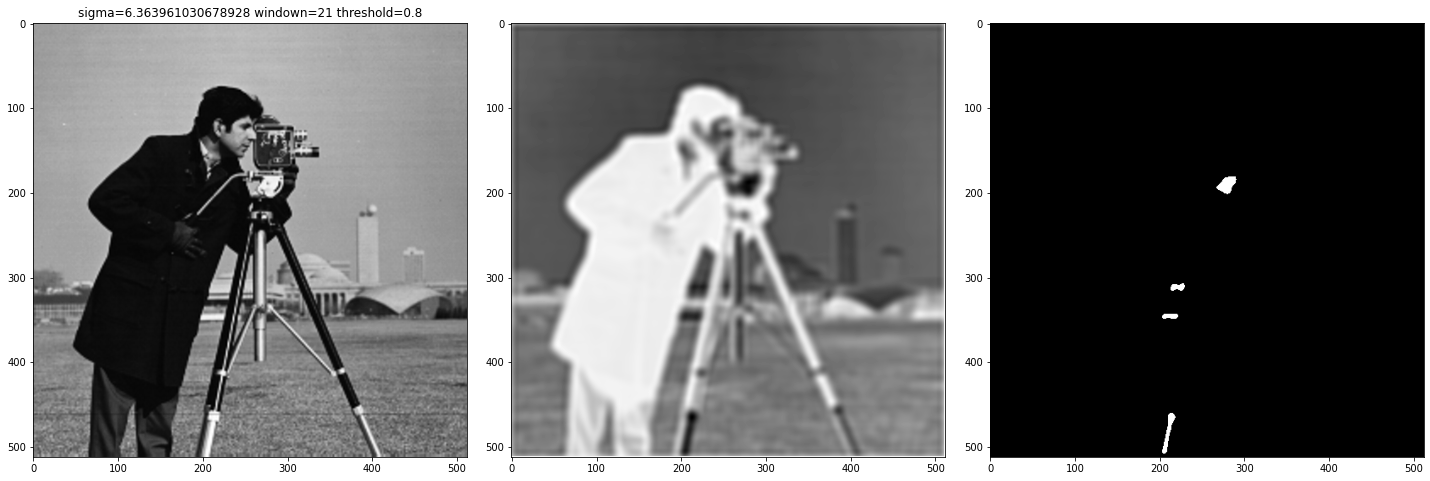

In [114]:
detect_blob(img, radius=9, t=0.8)

Na imagem abaixo foi usado  raio de 15 e limiar de 80%, como pode ser visto, o algoritmo destacou as regiões das frutas que estavam refletino luz.

In [ ]:
img = imgs_i[3]
for radius in [3,9,15,19,25]:
    for t in [0.1, 0.3, 0.6, 0.7, 0.8]:
        detect_blob(img, radius, t=t)

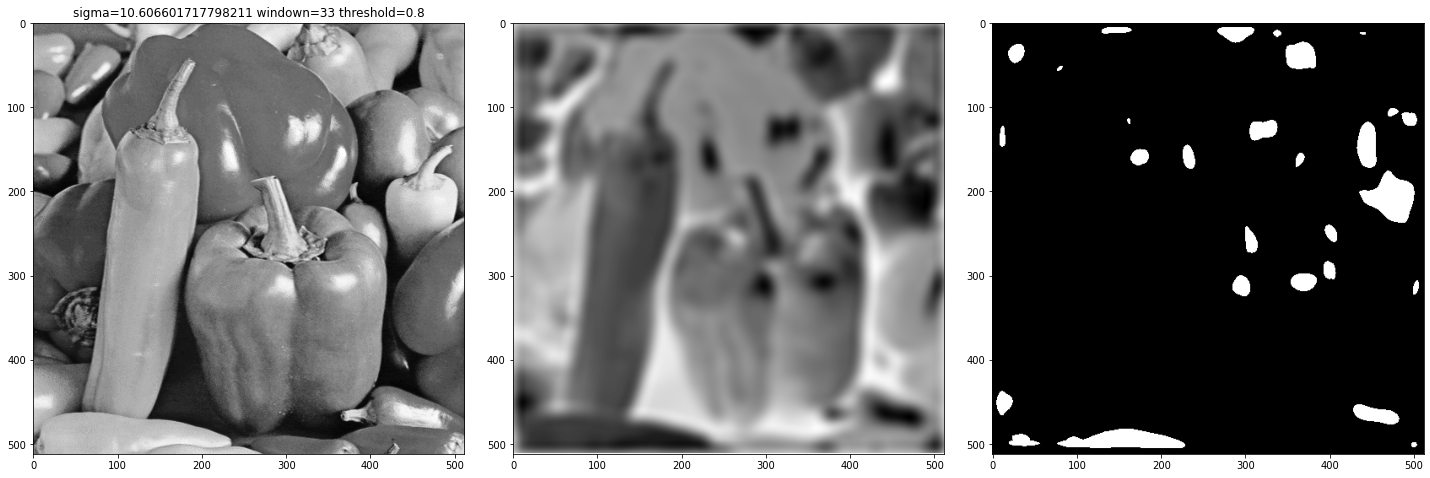

In [116]:
detect_blob(img, radius=15, t=0.8)

Como pode ser observado, com raio de 15 e limiar de 30% foram detectados a maioria das células

In [ ]:
img = imgs_i[4]
for radius in [3,9,15,19,25]:
    for t in [0.1, 0.3, 0.6, 0.7, 0.8]:
        detect_blob(img, radius, t=t)

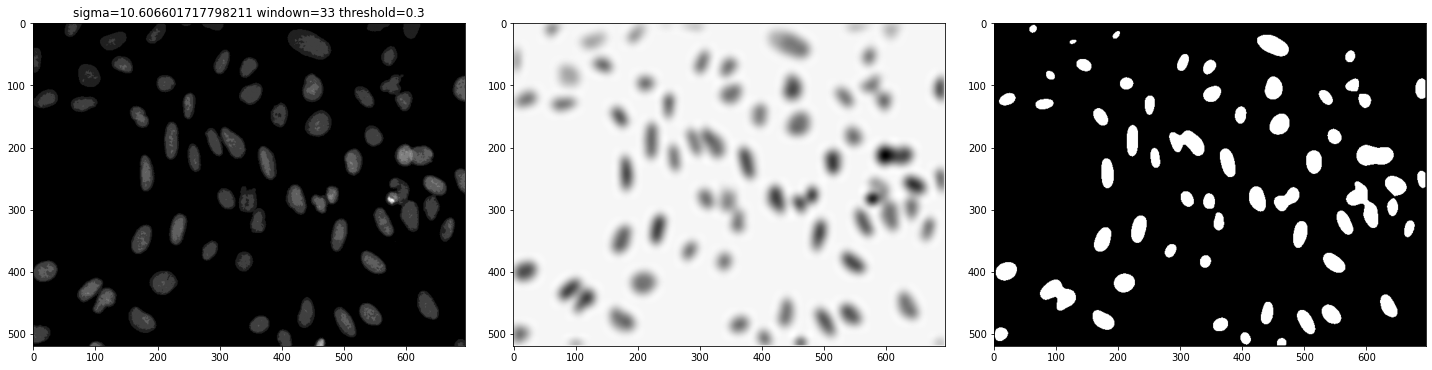

In [128]:
detect_blob(img, radius=15, t=0.3)

### Ex 2:

**● Implemente um algortimo que seja capaz de detectar apenas
arestas verticais com mais de 5 pixels de largura e menos de 7.**

**– Use um limiar mínimo de 5 níveis de intensidade para considerar que o
ponto é de rampa.**

**● A rampa deve ter a variação na mesma direção**

**● Se for menos que isso, considere que não há variação – região plana**

**● Faça uma implementação que suavize os ruídos antes de detectar.**

**– Compare os resultados com e sem a filtragem sobre algumas imagens
que escolher.**

**● Faça esses experimentos sobre 5 imagens de sua escolha, como o
exercício anterior.**

**– Use a intensidade para detectar as arestas.**

Inicialmente, o código abaixo foi usado para criar os núcleos dos filtros de suavisação gaussiano e o filtro usado para detecção de bordas verticais.

In [97]:
#cria o núcleo de um filtro de suavização gaussiano com tamanho shape e desvio sigma
def gaussian_kernel(shape, sigma):
    center = [int(shape[0]/2),int(shape[0]/2)]
    out = np.zeros(shape[:2])
    for i in range(shape[0]):
        for j in range(shape[1]):
            out[i,j] = (1.0/(2.0*pi*sigma**2))*exp(-(((i-center[0])**2+(j-center[1])**2 )/(2.0*sigma**2)))
    return out

vertical_kernel = np.array([[-1,2,-1],
                            [-1,2,-1],
                            [-1,2,-1]])

As seguintes 5 imagens foram escolhidas para realização dos experimentos

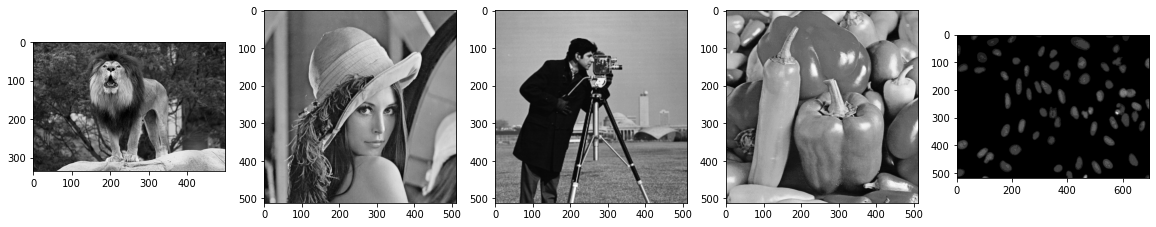

In [10]:
images_path = [ 'lion.jpg',
                'data/aula04/standard_test_images/lena_color_512.tif',
                'data/aula04/standard_test_images/cameraman.tif',
                'data/aula04/standard_test_images/peppers_color.tif',
                'data/aula05/cells/IXMtest_A01_s1_w164FBEEF7-F77C-4892-86F5-72D0160D4FB2.tif']

fig = plt.figure(figsize=(20, 10))
imgs = []
i=1
for path in images_path:
    img = bgr_to_rgb(cv.imread(path, 1))
    img = Intensity(rescale(img, 0, 255))
    imgs += [img]
    
    fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray')
    i+=1

O seguinte protocolo foi seguido para detectar as arestas verticais:

- É aplicado um filtro gaussiano na imagem com os seguintes valores de sigma: 1,2 e 3, sendo o tamanho do núcleo definido como 3*sigma.
Foi realizado um experimento sem filtragem também para comparação.

- É aplicado então o filtro para detecção de bordas verticais na imagem.

- É usada então a função vertical_edge_detector para encontrar as arestas com largura entre 5 e 7 pixels.

Nessa função,  cada linha da imagem gerada pelo filtro de detcção de bordas verticais é percorrida, procurandoo por pixels com excedam um determinado valor absoluto (1% do máximo), procura-se então outro pixel com sinal invertido que atenda essa exigência e que esteja a mais de 5 pixels de distância e menos 7 na mesma linha, esses serão os pontos que marcam o início e o fim da rampa.

Na imagem original, é verificado se rampa tem intensidade de no mínimo 5 níveis diferentes, e se ela tem a mesma direção.

O código dessa função pode ser conferido abaixo.

In [100]:
def vertical_edge_detector(img, v_img, v_img_threshold_ratio, img_threshold):
    t_img = np.zeros(v_img.shape)
    
    v_img_max = v_img.max()
    v_img_min = v_img.min()
    if v_img_max < abs(v_img.min()):
        v_img_max = abs(v_img.min())
    
    v_img_threshold = v_img_max*v_img_threshold_ratio

    for x in range(v_img.shape[0]):
        begin = None
        diretion = None
        for y in range(v_img.shape[1]):
            if abs(v_img[x,y]) > v_img_threshold:
                if begin is None:
                    begin = y
                    direction = v_img[x,y]>0
                elif direction != ( v_img[x,y]>0 ) and y-begin>=5 and y-begin<=7:
                    valid =True
                    last_direction = None
                    for k in range(begin, y+1):
                        
                        if last_direction==None:
                            last_p_direction= (img[x,k]-img[x,begin-1])>0
                        
                        if abs(img[x,k]-img[x,begin-1])<img_threshold:
                            valid=False
                            
                        p_direction = (img[x,k]-img[x,k-1])>=0
                        if p_direction!=last_p_direction:
                            valid=False
                    if valid:
                        t_img[x,int((begin+y)/2)] = 1
                    begin = None
                    diretion = None
                elif  y-begin>=7:
                    begin = None
                    diretion = None
    return t_img

E o código abaixo descreve os experimentos realizados, onde na figura, a primeira coluna mostra a imagem suavizada, a segunda a reesultado da aplicação do núcleo de detecção de bordas verticais, e a terceira a imagem após a detecção das arestas.

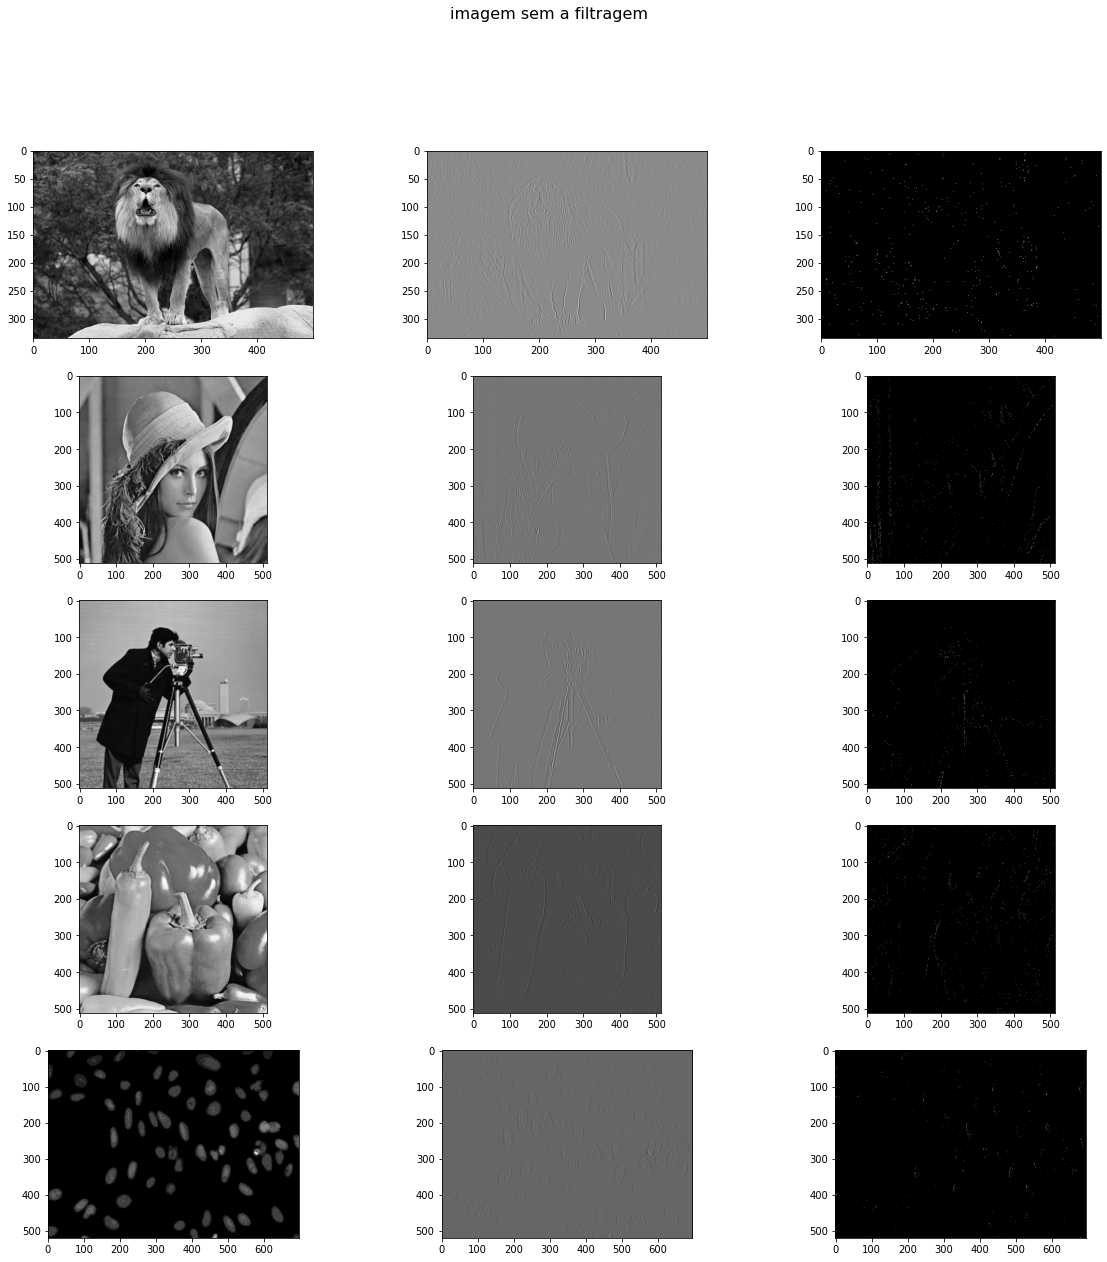

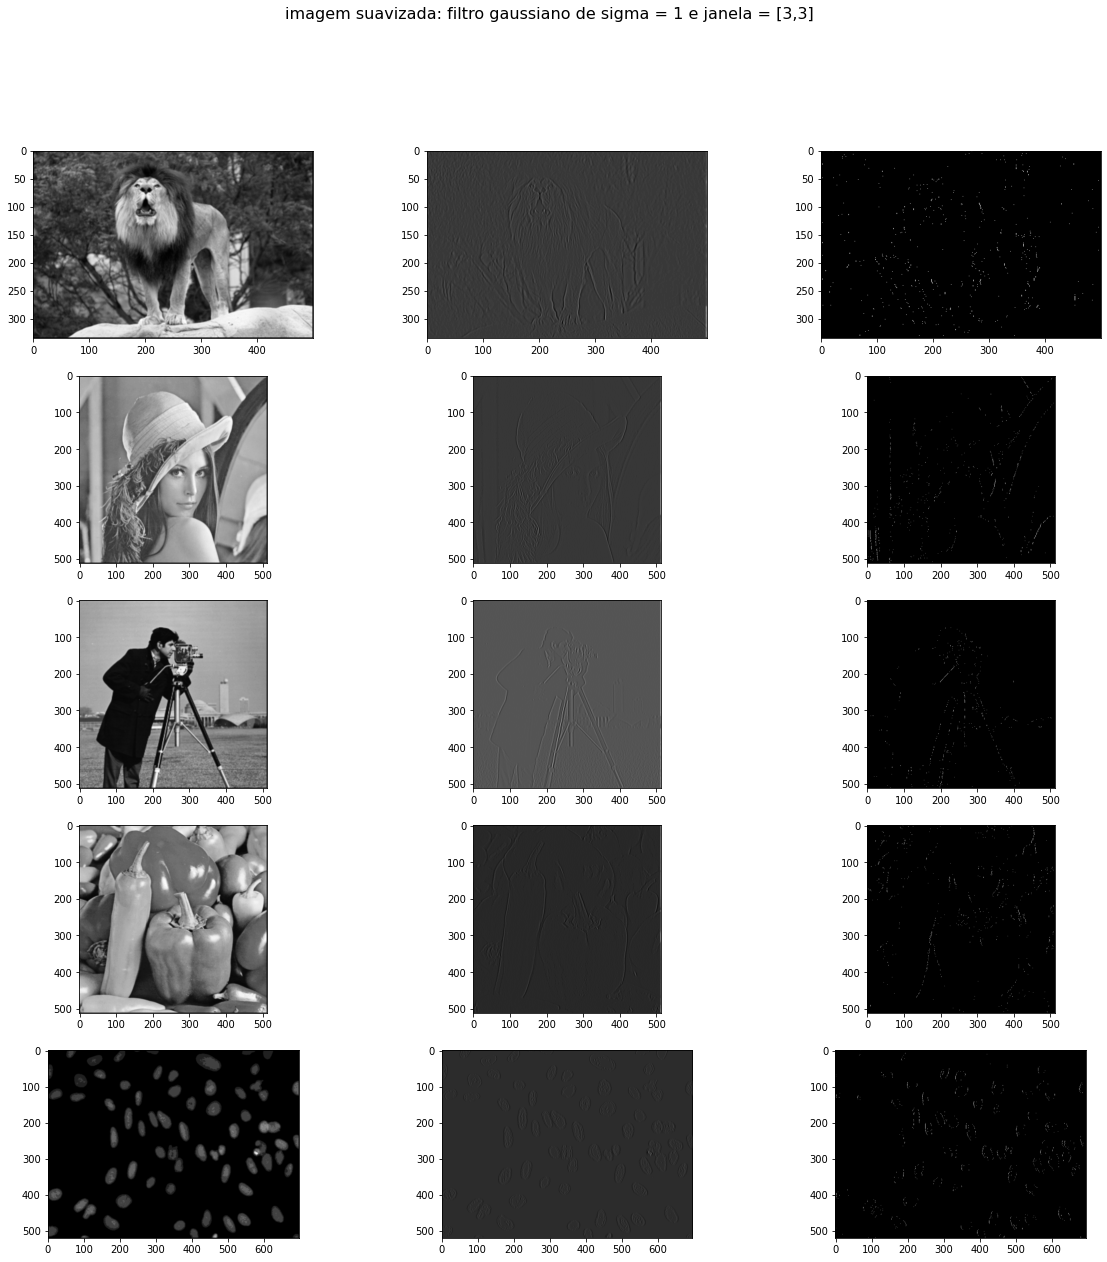

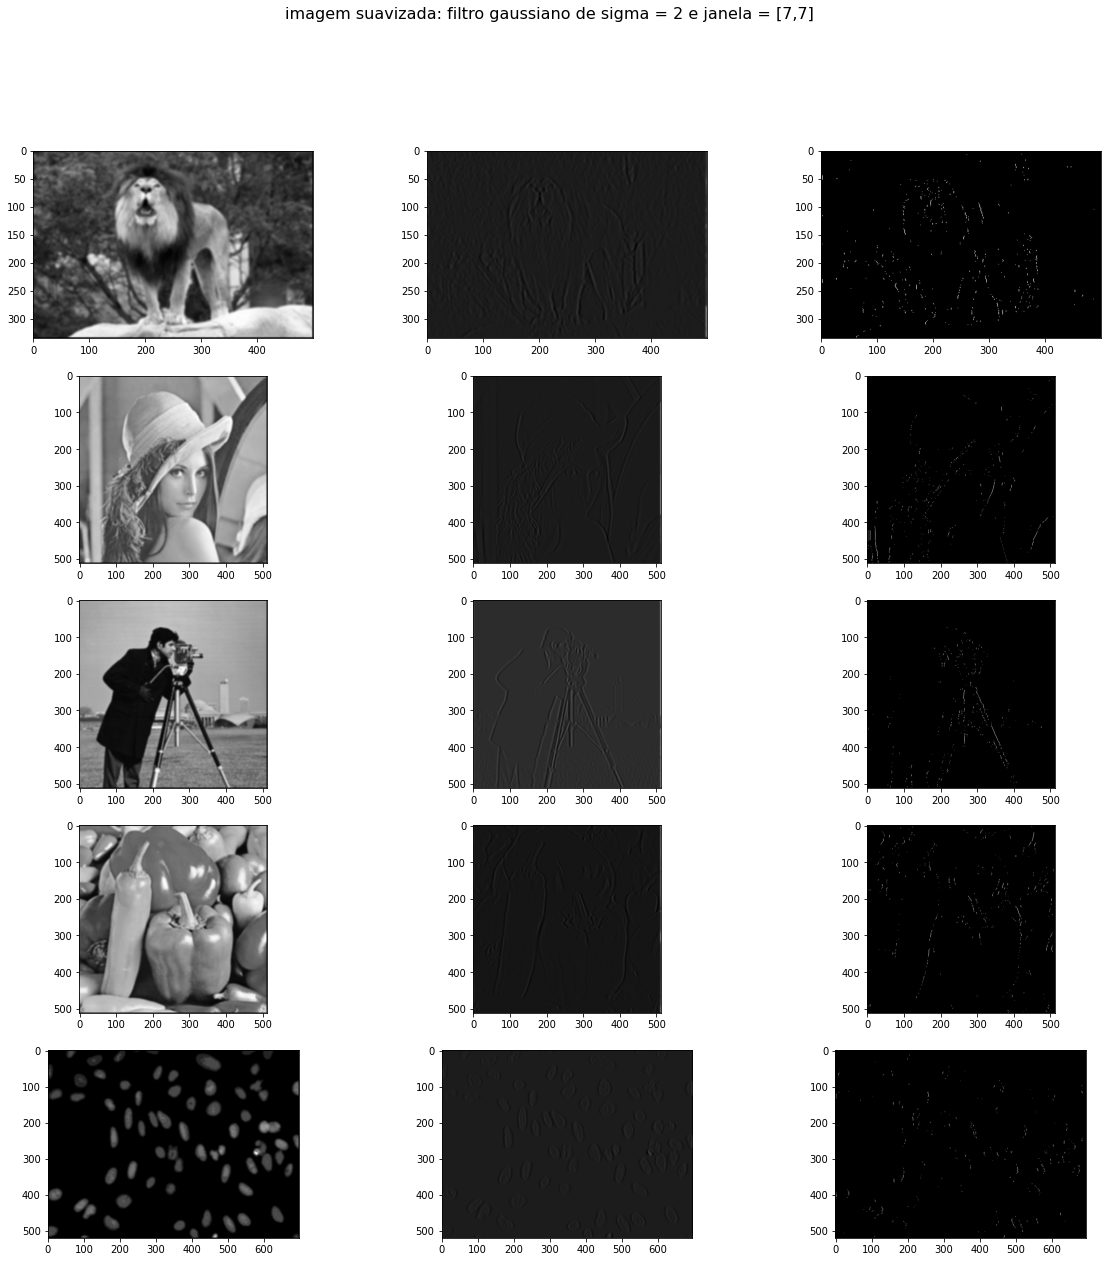

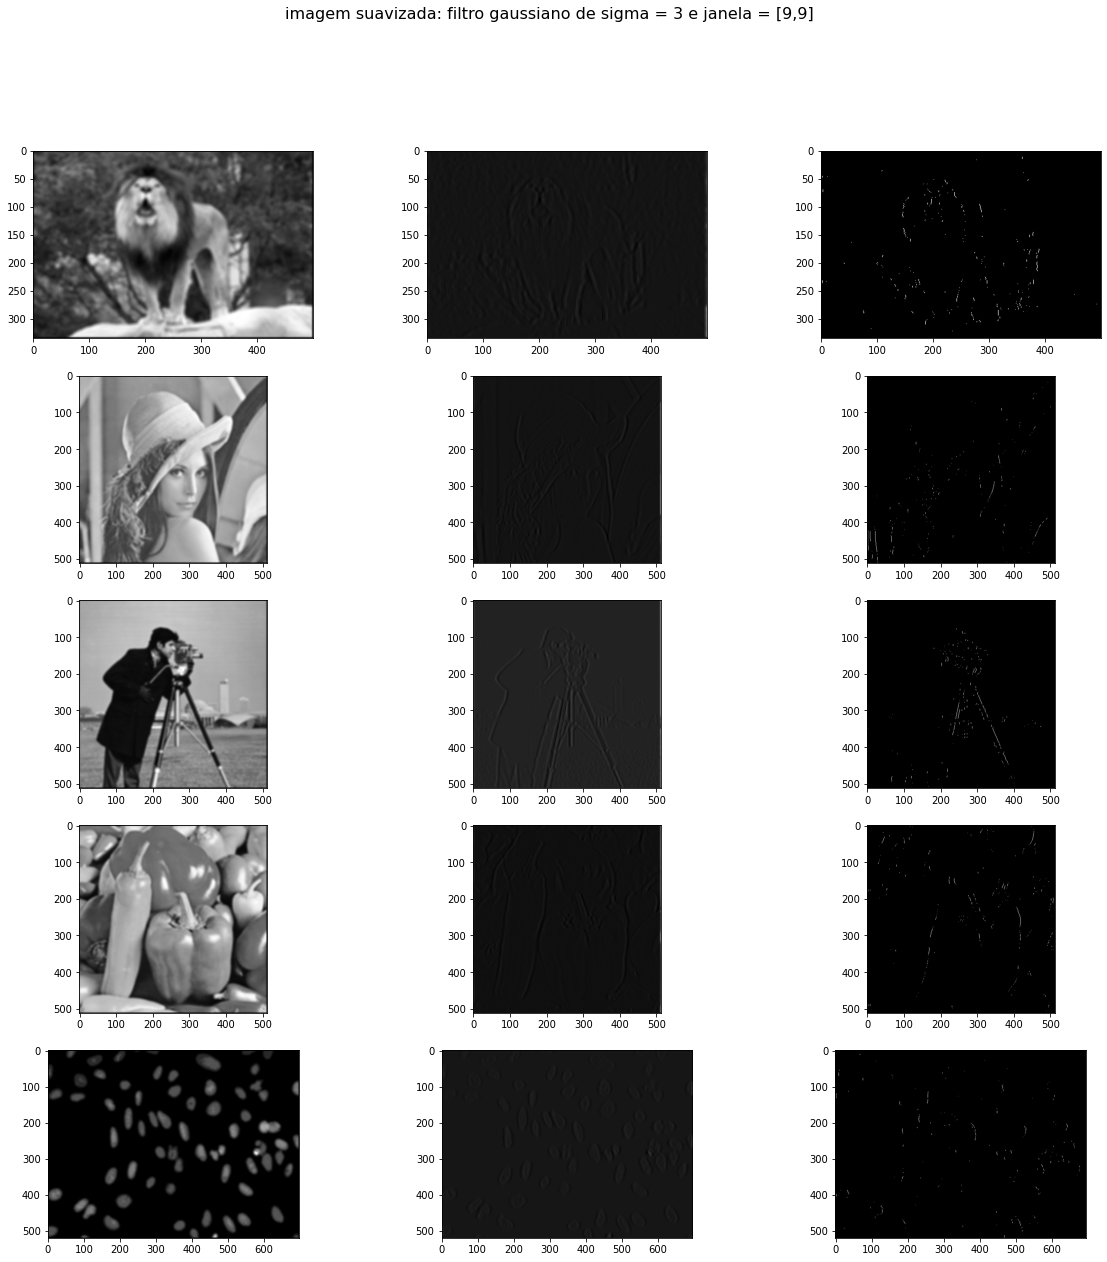

In [102]:
for sigma in [0,1,2,3]:
    
    size = int(3*sigma)
    if size%2==0:
        size+=1
    if sigma!=0:
        kernel = gaussian_kernel([size,size], sigma)
    
    i=1
    fig = plt.figure(figsize=(20, 20))
    if sigma!=0:
        fig.suptitle(
            'imagem suavizada: filtro gaussiano de sigma = '+str(sigma)+
            ' e janela = ['+str(size)+','+str(size)+']',fontsize=16)
    else:
        fig.suptitle('imagem sem a filtragem',fontsize=16)
    
    for img in imgs:
        if sigma!=0:
            co_img = correlation(img, kernel)
            co_img = rescale(co_img, 0, 255)
        else:
            co_img = img
        v_img = correlation(co_img, vertical_kernel)

        fig.add_subplot(len(imgs), 3 , i)
        plt.imshow(co_img, cmap='gray')
        
        
        fig.add_subplot(len(imgs), 3 , i+1)
        plt.imshow(v_img, cmap='gray')
        
        t_img = vertical_edge_detector(co_img, v_img, v_img_threshold_ratio=0.01, img_threshold=5)
        fig.add_subplot(len(imgs), 3 , i+2)
        plt.imshow(t_img, cmap='gray')
                
        i+=3

No geral, pode ser observado que foram detectados poucos pontos, sendo necessário melhorar o desempenho do método, e/ou usar uma estratégia para conectar os pontos detectados. No entanto, os pontos detectados destacam algumas bordas verticais proeminentes na imagem, como por exemplo a face do leão; O nariz, rosto e chapéu da Lenna; O tripé da câmera; O cortono de algumas frutas; E o contorno de algumas células

Pode ser observado um ganho de desempenho com a aplicação do filtro de suavização, de forma que filtros maiores levaram a detecção de linhas mais continuas na imagem, no entanto, para os núcleos maiores, foi perdido alguns detalhes detectados anteriormente. Recomendaria o uso de sigma=2, por apresentar linhas mais continuas sem perder tantos detalhes quanto os valores mais altos.

### Ex 3:

**Use o algoritmo de Canny para identificar as
bordas dos contornos das células e dos seus
núcleos nas imagens escolhidas da base de
imagens de células da aula passada.**

No código abaixo foi utilizado a implementação do algoritmo de Canny do OpenCV para identificar o contorno das células e dos núcleos das imagens destacadas nos experimentos da aula anterior.

Foi utilizado os valores de 100 e 200 como valores de máximo e mínimo para identificação de uma borda (o mesmo utilizado no exemplo do site https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html).

As imagens a baixo mostram a imagem original (coluna 1), e o resultado do Canny utilizando o sobel com janelas de tamanho [3,3] (coluna 2), [5,5] (coluna 3) e [7,7] (coluna 4).

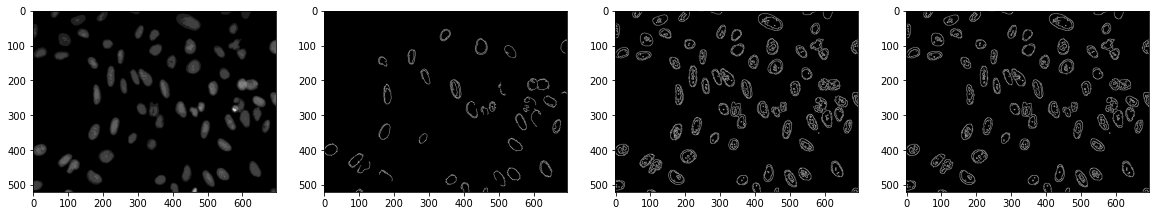

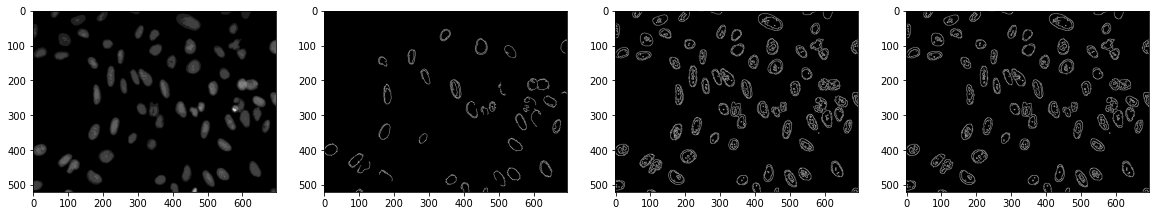

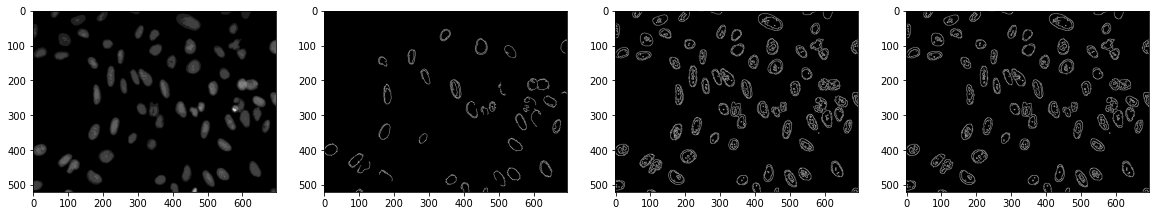

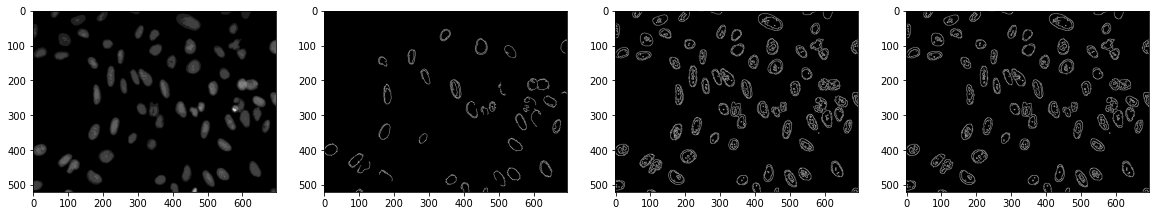

In [96]:
dir = 'data/aula04/selected'
img_names = list(os.listdir(dir))

for img_name in img_names:
    img = bgr_to_rgb(cv.imread(path, 1))
    img = Intensity(rescale(img, 0, 255))

    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 4 , 1)
    plt.imshow(img, cmap='gray')
    i=2
    for aperture_size in [3,5,7]:
        canny = cv.Canny(img.astype('uint8'), 100, 200, True, aperture_size )
        fig.add_subplot(1, 4 , i)
        plt.imshow(canny, cmap='gray')        
        i+=1
    

Como pode ser observado, para o sobel de janela [3,3], para algumas células não tiveram sua borda completamente detectadas, e na maioria, o núcleo não foi detectado.

Já para o Canny com sobel de janela [5,5] e [7,7], foram obtidos bons resultados, sendo detectado tanto as bordas quanto o núcleo das células com sucesso.